In [17]:

import pandas as pd
!pip install word2number
from word2number import w2n


In [18]:

# Load the dataset
df = pd.read_csv('../data/Raw/foodborne_outbreaks.csv')
df.head()


,ID,IdentificationtoFirstContact (days),IdentificationtoManagerInterview (days),IdentificationtoObservation (days),PercentWhoSoughtHealthcare,EstablishmentType,Site,FoodPreparationProcess,MenuType,MealsServedDaily,FoodIdentified,ContributingFactorIdentified,AgentIdentified,OnsettoIdentification (days),SampleType,EpidemiologyInvestigationMethod,VisitsforEnvironmentalAssessment
0,8533,2,2.0,2.0,3.0,Restaurant,66,Complex,American,GreatTwoHundred,True,False,True,3.0,Both,Interviews,2
1,6204,1,3.0,3.0,3.0,Restaurant,66,Complex,International,LessorEqualTwoHundred,False,False,True,3.0,Both,Interviews,2
2,6326,1,3.0,3.0,3.0,Restaurant,66,Complex,American,LessorEqualTwoHundred,False,False,True,3.0,Both,Interviews,2
3,6158,2,3.0,3.0,3.0,Restaurant,66,Complex,American,LessorEqualTwoHundred,True,True,True,3.0,Both,Interviews,2
4,6314,1,3.0,3.0,3.0,Restaurant,66,Complex,International,LessorEqualTwoHundred,True,False,True,3.0,Both,Interviews,2


## Inspecting the dataset

In [19]:
df.info()
df.describe(include='all')
df.isnull().sum()
# Check for duplicates
duplicates = df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 17 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   ID                                       306 non-null    int64  
 1   IdentificationtoFirstContact (days)      306 non-null    int64  
 2   IdentificationtoManagerInterview (days)  262 non-null    float64
 3   IdentificationtoObservation (days)       291 non-null    float64
 4   PercentWhoSoughtHealthcare               279 non-null    float64
 5   EstablishmentType                        306 non-null    object 
 6   Site                                     306 non-null    int64  
 7   FoodPreparationProcess                   306 non-null    object 
 8   MenuType                                 306 non-null    object 
 9   MealsServedDaily                         245 non-null    object 
 10  FoodIdentified                           306 non-n

### Visualizing Missing data

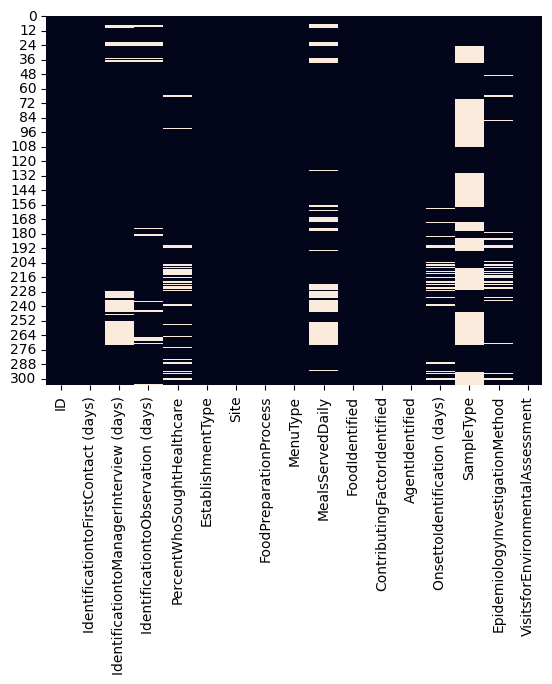

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(df.isnull(), cbar=False)
plt.show()


### Removing Unnecessary columns

In [23]:
df['ID'].is_unique  # if True, consider dropping
df.drop(columns=['ID'], inplace=True)  # drop if not needed

### Converting text to numerical

In [ ]:

import numpy as np
import re

def parse_meals_auto(value):
    if pd.isnull(value):
        return np.nan

    value = str(value).strip().lower()

    value = re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', value).replace('-', ' ')
    
    value = value.replace("lessor", "less or")

    # Convert words to number
    try:
        num = w2n.word_to_num(value)
    except:
        # Try to extract number-like word only
        match = re.search(r'(one|two|three|four|five|six|seven|eight|nine|ten|hundred|thousand|\d+)', value)
        if match:
            try:
                num = w2n.word_to_num(match.group())
            except:
                return np.nan
        else:
            return np.nan

    # Handle logic based on keywords
    if 'less than' in value:
        return num - 1
    elif 'less or equal' in value or 'less than or equal' in value:
        return num
    elif 'greater than' in value or 'great' in value:
        return num + 1
    elif 'greater or equal' in value:
        return num
    else:
        return num

# Apply to column
df['MealsServedDaily'] = df['MealsServedDaily'].apply(parse_meals_auto)

# Handle any remaining missing values
df['MealsServedDaily'] = df['MealsServedDaily'].fillna(df['MealsServedDaily'].median())
df['MealsServedDaily'] = df['MealsServedDaily'] * 100



# Convert to int
df['MealsServedDaily'] = df['MealsServedDaily'].astype(int)


### Handling Missing Values

In [30]:
df.isnull().sum()

IdentificationtoFirstContact (days)          0
IdentificationtoManagerInterview (days)     44
IdentificationtoObservation (days)          15
PercentWhoSoughtHealthcare                  27
EstablishmentType                            0
Site                                         0
FoodPreparationProcess                       0
MenuType                                     0
MealsServedDaily                             0
FoodIdentified                               0
ContributingFactorIdentified                 0
AgentIdentified                              0
OnsettoIdentification (days)                22
SampleType                                 157
EpidemiologyInvestigationMethod             24
VisitsforEnvironmentalAssessment             0
dtype: int64

### Visualizing distribution

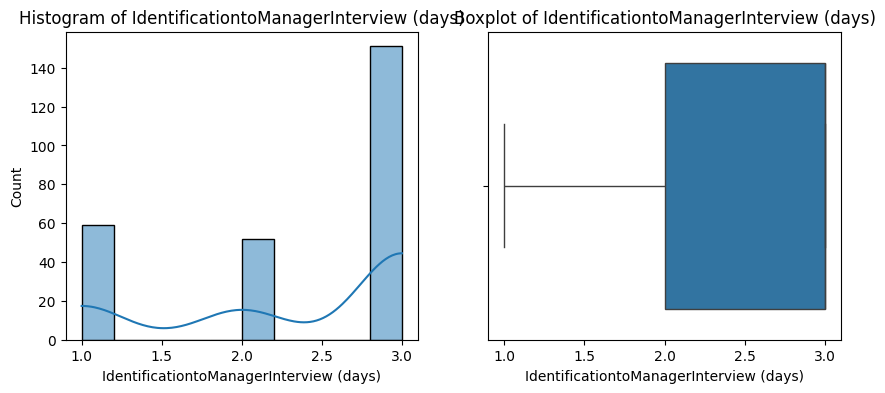

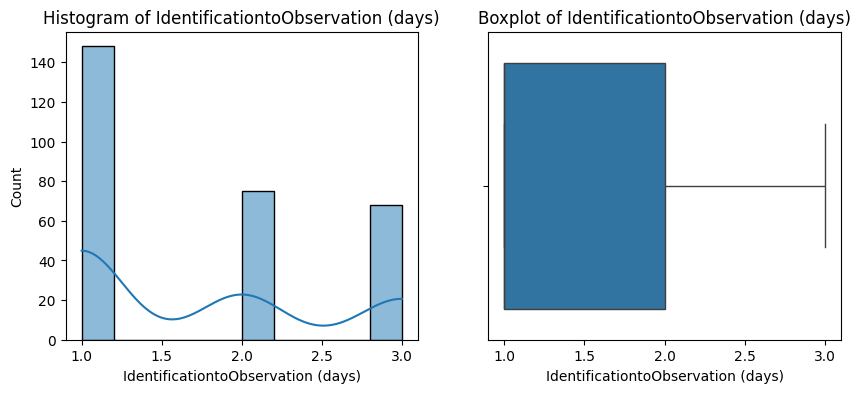

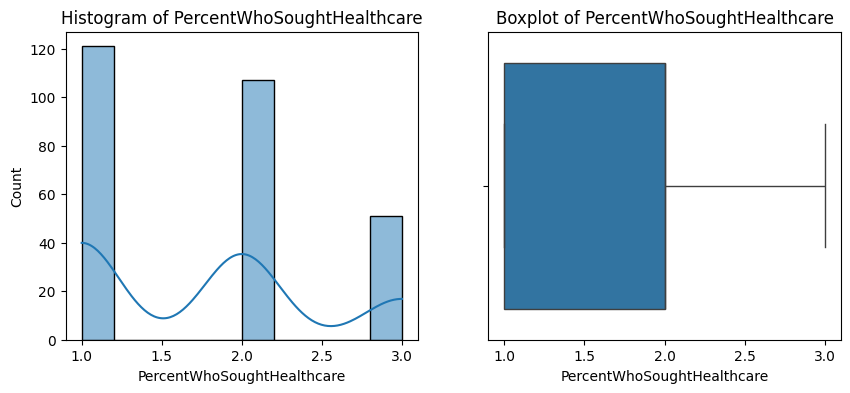

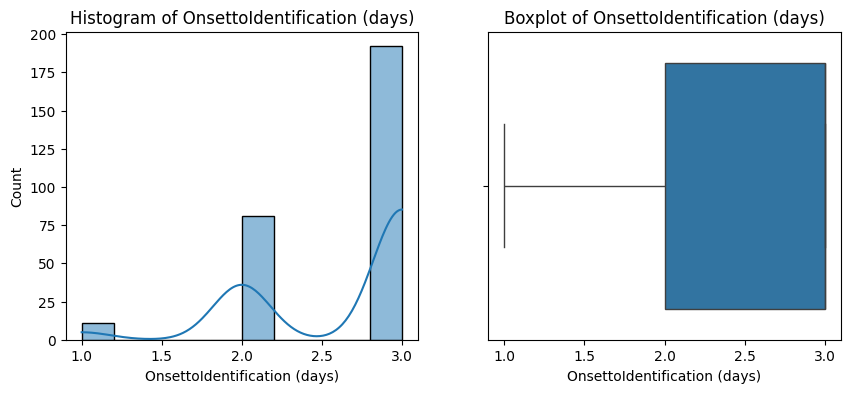

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

cols_to_check = [
    'IdentificationtoManagerInterview (days)',
    'IdentificationtoObservation (days)',
    'PercentWhoSoughtHealthcare',
    'OnsettoIdentification (days)'
]

for col in cols_to_check:
    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Histogram of {col}')
    
    plt.subplot(1,2,2)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    
    plt.show()


In [32]:
for col in cols_to_check:
    skew = df[col].skew()
    print(f'{col} skewness: {skew:.2f}')


IdentificationtoManagerInterview (days) skewness: -0.73
IdentificationtoObservation (days) skewness: 0.55
PercentWhoSoughtHealthcare skewness: 0.44
OnsettoIdentification (days) skewness: -1.24


#### Insight
 Since the  distributions of these variables are skewed we replace missing values with the median instead of mean

#### Fillling Numerical values

In [33]:
numeric_median_fill = [
    'IdentificationtoManagerInterview (days)',
    'IdentificationtoObservation (days)',
    'PercentWhoSoughtHealthcare',
    'OnsettoIdentification (days)'
]

for col in numeric_median_fill:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)
    print(f"Filled missing values in '{col}' with median: {median_val}")


Filled missing values in 'IdentificationtoManagerInterview (days)' with median: 3.0
Filled missing values in 'IdentificationtoObservation (days)' with median: 1.0
Filled missing values in 'PercentWhoSoughtHealthcare' with median: 2.0
Filled missing values in 'OnsettoIdentification (days)' with median: 3.0


#### Filling Categorical Values

In [35]:
categorical_mode_fill = ['SampleType', 'EpidemiologyInvestigationMethod']

for col in categorical_mode_fill:
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val)
    print(f"Filled missing values in '{col}' with mode: {mode_val}")
df.isnull().sum()

Filled missing values in 'SampleType' with mode: Clinical
Filled missing values in 'EpidemiologyInvestigationMethod' with mode: Casecontrol


IdentificationtoFirstContact (days)        0
IdentificationtoManagerInterview (days)    0
IdentificationtoObservation (days)         0
PercentWhoSoughtHealthcare                 0
EstablishmentType                          0
Site                                       0
FoodPreparationProcess                     0
MenuType                                   0
MealsServedDaily                           0
FoodIdentified                             0
ContributingFactorIdentified               0
AgentIdentified                            0
OnsettoIdentification (days)               0
SampleType                                 0
EpidemiologyInvestigationMethod            0
VisitsforEnvironmentalAssessment           0
dtype: int64

#### Converting float to integer

In [37]:
cols_to_int = [
    'IdentificationtoManagerInterview (days)',
    'IdentificationtoObservation (days)',
    'OnsettoIdentification (days)'
]

for col in cols_to_int:
    df[col] = df[col].astype(int)
    print(f"Converted '{col}' to integer.")


Converted 'IdentificationtoManagerInterview (days)' to integer.
Converted 'IdentificationtoObservation (days)' to integer.
Converted 'OnsettoIdentification (days)' to integer.


#### Saving the Cleaned Data

In [38]:
df.to_csv('cleaned_data.csv', index=False)
